In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

# load data
url = 'https://github.com/facebook/prophet/blob/main/examples/example_retail_sales.csv?raw=true'
dt = pd.read_csv(url)

# format data
dt['ds'] = pd.to_datetime(dt['ds']) # convert to datetime
dt.columns = ['date', 'sales'] # rename columns

# create lagged variables
dt['lag1'] = dt['sales'].shift(1)
dt['lag2'] = dt['sales'].shift(2)
dt['lead1'] = dt['sales'].shift(-1)
dt['lead2'] = dt['sales'].shift(-2)

# Convert 'date' column to numerical features
dt['year'] = dt['date'].dt.year
dt['month'] = dt['date'].dt.month

# save date for later
dates = dt['date']
dt = dt.drop(columns=['date'])

In [2]:
# Step 1: Fit a Linear Trend Model
dt['time_index'] = np.arange(len(dt))  # Create a time index for linear regression
trend_model = LinearRegression()
trend_model.fit(dt[['time_index']], dt['sales'])  # Fit trend model
dt['trend'] = trend_model.predict(dt[['time_index']])  # Extract trend component

# Step 2: Detrend the Data (Sales - Trend)
dt['sales_detrended'] = dt['sales'] - dt['trend']

In [3]:
# train - test split
test_period_index = int(len(dt) * 0.8)
train_data = dt.iloc[:test_period_index]
test_data = dt.iloc[test_period_index:]

In [4]:
X_train = train_data.drop(columns=['sales', 'sales_detrended', 'trend', 'time_index'])
y_train = train_data['sales_detrended']  # Train on detrended sales
X_test = test_data.drop(columns=['sales', 'sales_detrended', 'trend', 'time_index'])    
y_test = test_data['sales_detrended']

In [5]:
# Fit the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)
# Make predictions
y_train_pred_detrended = model.predict(X_train)
y_test_pred_detrended = model.predict(X_test)

y_train_pred = y_train_pred_detrended + train_data['trend'].values
y_test_pred = y_test_pred_detrended + test_data['trend'].values

# evaluate the model
rmse = root_mean_squared_error(y_test, y_test_pred_detrended)
print(f'RMSE : {rmse:.2f}')


results = pd.DataFrame({
    'date': dates,
    'y_actual': np.concatenate([train_data['sales'], test_data['sales']]),
    'y_train_pred': np.concatenate([y_train_pred, [np.nan] * len(y_test)]),  
    'y_test_pred': np.concatenate([[np.nan] * len(y_train), y_test_pred])
})


results_df = pd.DataFrame(results)

RMSE : 14062.27


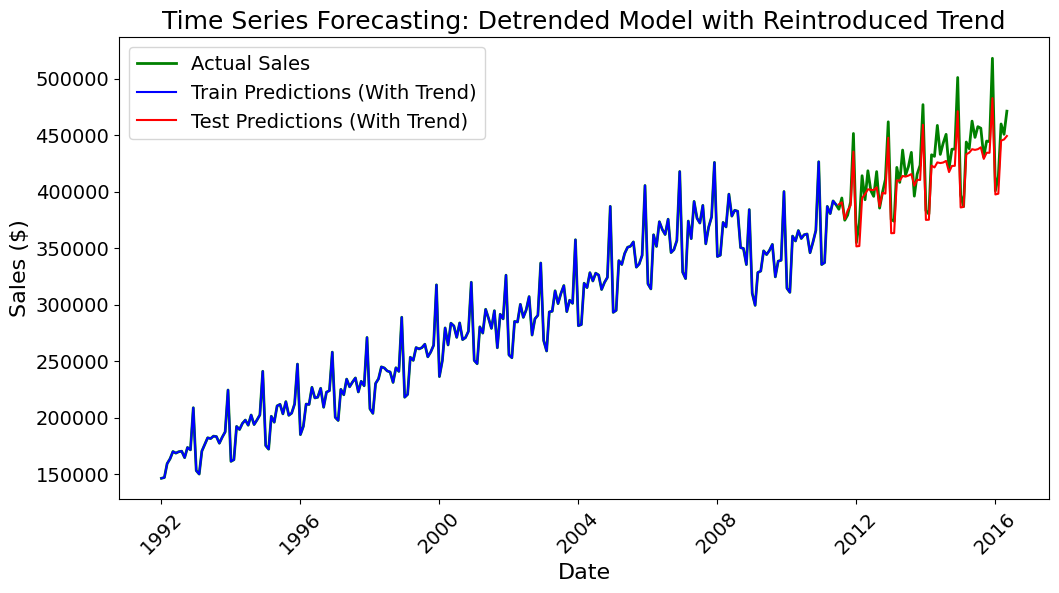

In [14]:
# Plot the actual, training, and test predictions
plt.figure(figsize=(12, 6))
fontsize = 16
plt.plot(results['date'], results['y_actual'], label="Actual Sales", color='green', linewidth=2)
plt.plot(results['date'], results['y_train_pred'], label="Train Predictions (With Trend)", color='blue', linestyle='-')
plt.plot(results['date'], results['y_test_pred'], label="Test Predictions (With Trend)", color='red', linestyle='-')

plt.xlabel("Date", fontsize=fontsize)
# rotate x label
plt.xticks(fontsize=fontsize-2, rotation=45)
plt.yticks(fontsize=fontsize-2)
plt.ylabel("Sales ($)", fontsize=fontsize)
plt.title("Time Series Forecasting: Detrended Model with Reintroduced Trend", fontsize = fontsize+2)
plt.legend(fontsize = fontsize-2)
plt.show()


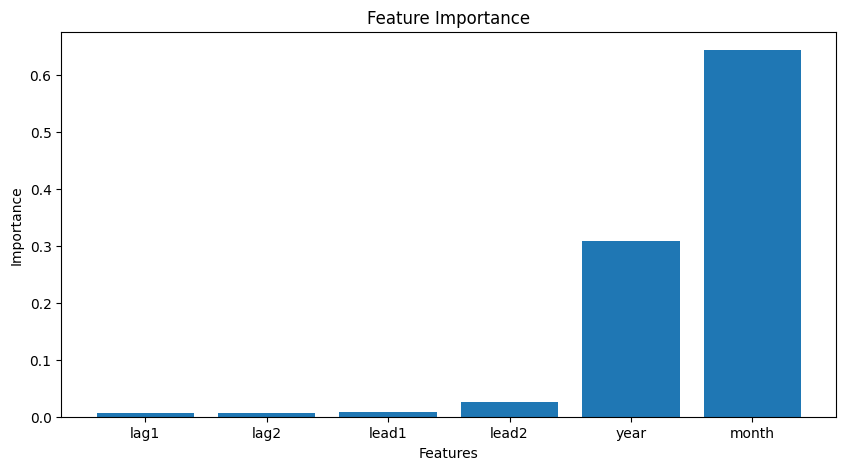

In [7]:
#importance of features
feature_importance = model.feature_importances_
features = X_train.columns
plt.figure(figsize=(10, 5))
plt.bar(features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [8]:
# mean absolute error in forecasting
mae = np.mean(np.abs(y_test - y_test_pred))
print(f'Mean Absolute Error: {mae:.2f}')

Mean Absolute Error: 412686.64


<Figure size 1000x2000 with 0 Axes>

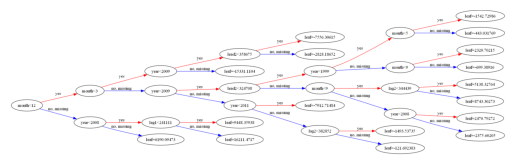

In [9]:
# plot the tree
from xgboost import plot_tree
plt.figure(figsize=(10, 20))
plot_tree(model, num_trees=0, rankdir='LR')
# Display the plot
plt.show()

In [10]:
from xgboost import to_graphviz

# Generate Graphviz representation of the tree
dot = to_graphviz(model, num_trees=0, rankdir='LR')

# Save the Graphviz output to a file or render it
dot.render("tree", format="png")  # Save as PNG

'tree.png'